In [8]:
import Finches as dcst
# contains many functions important for hacker stats and statistical inference

In [6]:
help(dcst.ecdf)

Help on function ecdf in module Finches:

ecdf(data)
    Compute ECDF for a one-dimensional numpy array.



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Earthquakes in Parkfield Region

In [10]:
parkfield = pd.read_csv('parkfield_earthquakes_1950-2017.csv', comment='#', usecols=['time','mag'])

In [11]:
mags = np.array(parkfield['mag'])

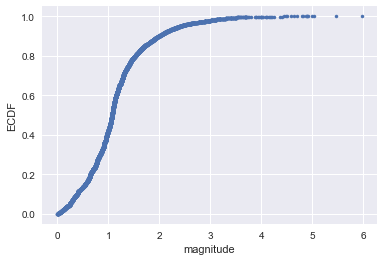

In [12]:
# Using *, the "splat" operator
plt.plot(*dcst.ecdf(mags), marker='.', linestyle='none')

plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.show()

There's a bit of roll-off for low magnitude quakes, but otherwise the ECDF looks exponential.  This is consistent with the Gutenberg--Richter Law. (How to discern between roll-off and a Gaussian distribution)

The $b$-value measures the seismicity of a region, in this case the Parkfield region of California along the San Andreas fault.  We impose a completeness threshold that excludes low magnitude quakes, which are difficult to detect.

In [13]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold
    m = mags[mags >= mt]

    # Compute b-value
    b = (np.mean(m) - mt) * np.log(10)

    # Draw bootstrap replicates (with replacement)
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m,np.mean,size=n_reps)

        # Compute b-value from replicates
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval for b-value
        conf_int = np.percentile(b_bs_reps,perc)
    
        return b, conf_int

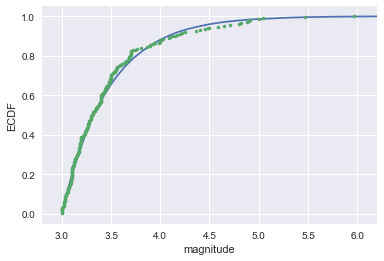


b-value: 1.08
95% conf int: [0.94, 1.24]


In [14]:
# Compute b-value and 95% confidence interval for Parkfield region, with mt = 3
b, conf_int = b_value(mags, 3, perc=[2.5, 97.5], n_reps=10000)

# Generate samples for theoretical ECDF
m_theor = np.random.exponential(b/np.log(10), size=100000) + 3

# Plot the theoretical CDF
plt.plot(*dcst.ecdf(m_theor))

# Plot the ECDF on the same graph
plt.plot(*dcst.ecdf(mags[mags >= 3]), marker='.', linestyle='none')

plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.xlim(2.8, 6.2)
plt.show()

# Report the results
# Need triple quotes here?
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

Now we shift focus from magnitudes of earthquakes to their timing.  In particular, we consider the distribution of inter-earthquake times.  These are times (timedeltas) between major quakes in the Parkfield region, since 1850.  Since our dataset only includes earthquakes from 1950 on, we don't use it for this analysis.

Instead, according to https://earthquake.usgs.gov/research/parkfield/pressrelease.html and https://en.wikipedia.org/wiki/Parkfield_earthquake, major earthquakes occurred in the region in 1857, 1881, 1901, 1922, 1934, 1966, and 2004.  "Major" is defined as having a magnitude above 5.5 and excluding aftershocks.

In [121]:
from datetime import datetime, timedelta

In [106]:
quake_years_str = ['1857-01-09', '1881-02-02', '1901-03-03', '1922-03-10', '1934-06-08', '1966-06-28', '2004-09-28']
quake_years_dt = []

for year in quake_years_str:
    year_dt = datetime.strptime(year, '%Y-%m-%d')
    quake_years_dt.append(year_dt)

In [108]:
quake_years_dt

[datetime.datetime(1857, 1, 9, 0, 0),
 datetime.datetime(1881, 2, 2, 0, 0),
 datetime.datetime(1901, 3, 3, 0, 0),
 datetime.datetime(1922, 3, 10, 0, 0),
 datetime.datetime(1934, 6, 8, 0, 0),
 datetime.datetime(1966, 6, 28, 0, 0),
 datetime.datetime(2004, 9, 28, 0, 0)]

In [109]:
quake_years_diff = []

for i in range(1,len(quake_years_dt)):
    year_diff = quake_years_dt[i] - quake_years_dt[i-1]
    quake_years_diff.append(year_diff)

In [110]:
quake_years_diff

[datetime.timedelta(8790),
 datetime.timedelta(7333),
 datetime.timedelta(7677),
 datetime.timedelta(4473),
 datetime.timedelta(11708),
 datetime.timedelta(13972)]

In [119]:
quake_yrs_diff_flt = []

for dt in quake_years_diff:
    dt_flt = (dt / timedelta(days=1)) / 365.25 # 365.25 days per year!
    quake_yrs_diff_flt.append(dt_flt)

In [120]:
quake_yrs_diff_flt

[24.06570841889117,
 20.076659822039698,
 21.018480492813143,
 12.24640657084189,
 32.054757015742645,
 38.25325119780972]

In [122]:
time_gap = np.array(quake_yrs_diff_flt)

In [133]:
import dc_stat_think as dcst2

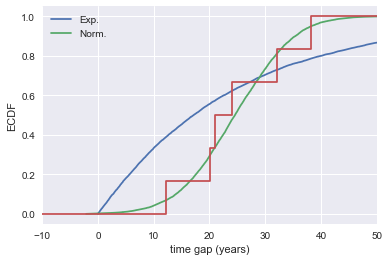

In [134]:
# Compute the mean time gap
mean_time_gap = np.mean(time_gap)

# Standard deviation of the time gap
std_time_gap = np.std(time_gap)

# Generate theoretical exponential distribution of timings
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

# Generate theoretical normal distribution of timings
time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Plot theoretical CDFs
plt.plot(*dcst.ecdf(time_gap_exp))
plt.plot(*dcst.ecdf(time_gap_norm))

# Plot Parkfield ECDF
plt.plot(*dcst2.ecdf(time_gap, formal=True, min_x=-10, max_x=50))

plt.legend(('Exp.', 'Norm.'), loc='upper left')
plt.xlabel('time gap (years)')
plt.ylabel('ECDF')
plt.xlim(-10, 50) # Why also need this?
plt.show()

In [160]:
# 28 Sep is the 272nd day in a leap year
last_quake = quake_years_dt[6].year + 272.0 / 366.0
last_quake

2004.7431693989072

In [403]:
# ignoring timezone considerations
# 31536000 seconds per non-leap year
today = 2018 + (datetime.now() - datetime(2018,1,1)).total_seconds() / 31536000
today

2018.3583165970592

In [404]:
# Draw MORE samples from the exponential distribution AGAIN
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# Draw MORE samples from the normal distribution AGAIN
norm_samples = np.random.normal(mean_time_gap, std_time_gap, size=100000)

# No earthquake as of today, so only keep samples that are long enough!
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

# Compute the confidence intervals with medians
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

# Print the results
print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)

Exponential: [2018.95227187 2035.34731361 2109.08242777]
     Normal: [2019.39650051 2030.37910731 2046.10950276]


Vastly different 97.5th percentiles!  So which theoretical distribution, exponential or normal, is more consistent with the data?  We will perform Kolmogorov--Smirnov hypothesis tests.

In [164]:
def ecdf_formal(x, data):
    return np.searchsorted(np.sort(data), x, side='right') / len(data)
# Need side='right' because ECDF is fraction of samples in data less than OR EQUAL TO each x-value

In [170]:
def ks_stat(data1, data2):
    # Data will be samples from the theoretical distribution we have chosen
    # Compute ECDF from data
    x,y = dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = ecdf_formal(x, data2)

    # Compute distances between concave corners and CDF
    D_top = abs(y - cdf)

    # Compute distance between convex corners and CDF
    D_bottom = abs((y - 1/len(data1)) - cdf)

    return np.max((D_top, D_bottom)) # maximum of the concatenation of the arrays D_top, D_bottom

In [171]:
def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
# Two args for normal, one arg for exponential
    # Generate samples from target distribution
    x_f = f(*args, size=size)
    
    # Initialize K-S replicates
    reps = np.empty(n_reps)
    
    # Draw replicates; each time data1 is different but data2 remains the same
    for i in range(n_reps):
        # Draw samples for comparison; n is length of original data set
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = ks_stat(x_samp, x_f)

    return reps

# Kolmogorov--Smirnov Tests

In [172]:
# Kolmogorov-Smirnov test
# Null hypothesis is that inter-earthquake times, for major quakes on a fault, are exponentially distributed
# Draw target distribution
x_f = np.random.exponential(mean_time_gap, size=10000)

# Compute K-S stat
d = ks_stat(time_gap, x_f)


# Draw K-S replicates
reps = draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('p =', p_val)

p = 0.2506


Despite our intuition that large quakes along a fault aren't independent events, we cannot reject the null hypothesis!

In [173]:
# Null hypothesis is that inter-earthquake times, for major quakes on a fault, are normally distributed
# Draw target distribution
x_f = np.random.normal(mean_time_gap, std_time_gap, size=10000)

# Compute K-S stat
d = ks_stat(time_gap, x_f)


# Draw K-S replicates
reps = draw_ks_reps(len(time_gap), np.random.normal, 
                         args=(mean_time_gap,std_time_gap), size=10000, n_reps=10000)

# Compute and print p-value
p_val = np.sum(reps >= d) / 10000
print('p =', p_val)

p = 0.9243


### Misc. Work

In [15]:
times = np.array(parkfield['time'])
times

array(['1951-10-03 13:44:33.170', '1953-05-28 07:58:34.510',
       '1961-12-14 11:51:15.410', ..., '2017-07-09 11:02:26.690',
       '2017-07-12 04:32:54.290', '2017-07-16 22:34:15.590'], dtype=object)

In [65]:
times_dt_list = []

for time in times:
    time_dt = times_dt_list.append(datetime.strptime(time[0:19], '%Y-%m-%d %H:%M:%S'))

In [66]:
times_dt = np.array(times_dt_list)

In [67]:
times_dt

array([datetime.datetime(1951, 10, 3, 13, 44, 33),
       datetime.datetime(1953, 5, 28, 7, 58, 34),
       datetime.datetime(1961, 12, 14, 11, 51, 15), ...,
       datetime.datetime(2017, 7, 9, 11, 2, 26),
       datetime.datetime(2017, 7, 12, 4, 32, 54),
       datetime.datetime(2017, 7, 16, 22, 34, 15)], dtype=object)

In [69]:
time_mag_dict = {}

for i in range(len(times_dt)):
    time_mag_dict[times_dt[i]] = mags[i] 

In [70]:
time_mag_dict

{datetime.datetime(1951, 10, 3, 13, 44, 33): 3.67,
 datetime.datetime(1953, 5, 28, 7, 58, 34): 3.61,
 datetime.datetime(1961, 12, 14, 11, 51, 15): 3.95,
 datetime.datetime(1965, 2, 21, 18, 39, 24): 3.54,
 datetime.datetime(1966, 6, 28, 4, 18, 36): 3.15,
 datetime.datetime(1966, 6, 28, 4, 26, 16): 5.47,
 datetime.datetime(1966, 6, 28, 4, 28, 36): 4.5,
 datetime.datetime(1966, 6, 28, 4, 34, 59): 3.24,
 datetime.datetime(1966, 6, 28, 4, 46, 20): 3.12,
 datetime.datetime(1966, 6, 28, 6, 32, 20): 3.76,
 datetime.datetime(1966, 6, 28, 23, 57, 25): 3.38,
 datetime.datetime(1966, 6, 29, 2, 19, 41): 3.9,
 datetime.datetime(1966, 7, 1, 1, 17, 36): 1.1,
 datetime.datetime(1966, 7, 1, 1, 55, 10): 0.3,
 datetime.datetime(1966, 7, 1, 2, 30, 10): 0.7,
 datetime.datetime(1966, 7, 1, 3, 1, 41): 2.1,
 datetime.datetime(1966, 7, 1, 3, 51, 35): 0.9,
 datetime.datetime(1966, 7, 1, 5, 46, 24): 1.1,
 datetime.datetime(1966, 7, 1, 6, 2, 35): 1.3,
 datetime.datetime(1966, 7, 1, 9, 8, 12): 0.6,
 datetime.dateti

In [79]:
parkfield['time_dt'] = times_dt

In [94]:
time_gaps = [timedelta(days = 999)]

for i in range(1,len(times_dt)):
    time_gaps.append(times_dt[i] - times_dt[i-1])

In [96]:
parkfield['time_gaps'] = time_gaps 

In [98]:
parkfield_2w = parkfield[parkfield['time_gaps'] > timedelta(days = 14)]

In [100]:
parkfield_2w.sort_values(by=['mag'], ascending = False)

,time,mag,time_dt,time_gaps
241,1967-08-12 18:57:42.380,4.09,1967-08-12 18:57:42,37 days 17:51:01
2,1961-12-14 11:51:15.410,3.95,1961-12-14 11:51:15,3122 days 03:52:41
2869,2002-09-06 07:28:22.590,3.90,2002-09-06 07:28:22,15 days 22:32:01
514,1977-11-29 16:42:01.680,3.70,1977-11-29 16:42:01,20 days 02:27:47
244,1969-12-10 13:25:34.370,3.68,1969-12-10 13:25:34,399 days 04:27:12
0,1951-10-03 13:44:33.170,3.67,1951-10-03 13:44:33,999 days 00:00:00
1,1953-05-28 07:58:34.510,3.61,1953-05-28 07:58:34,602 days 18:14:01
238,1967-03-13 21:59:48.930,3.60,1967-03-13 21:59:48,233 days 13:01:48
3,1965-02-21 18:39:24.500,3.54,1965-02-21 18:39:24,1165 days 06:48:09
246,1973-01-23 13:05:39.280,3.53,1973-01-23 13:05:39,677 days 01:06:40


# Hydraulic Fracturing (aka Fracking) in Oklahoma

In [264]:
oklahoma = pd.read_csv('oklahoma_earthquakes_1950-2017.csv', comment='#', usecols=['time','mag'])

In [265]:
times_array = np.array(oklahoma['time'])
mags_array = np.array(oklahoma['mag'])

In [309]:
times_array

array(['1974-12-16 02:30:21.400', '1975-09-13 01:25:02.800',
       '1975-10-12 02:58:11.200', ..., '2017-07-18 02:32:30.360',
       '2017-07-18 19:35:39.060', '2017-07-18 21:59:52.270'], dtype=object)

In [310]:
times_dt = []

for time in times_array:
    time_dt = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')
    times_dt.append(time_dt)

In [311]:
times_dt

[datetime.datetime(1974, 12, 16, 2, 30, 21, 400000),
 datetime.datetime(1975, 9, 13, 1, 25, 2, 800000),
 datetime.datetime(1975, 10, 12, 2, 58, 11, 200000),
 datetime.datetime(1975, 11, 29, 14, 29, 40, 900000),
 datetime.datetime(1976, 4, 16, 18, 59, 44, 200000),
 datetime.datetime(1976, 4, 19, 4, 42, 42, 200000),
 datetime.datetime(1979, 6, 7, 7, 39, 35, 600000),
 datetime.datetime(1979, 9, 13, 0, 49, 19, 800000),
 datetime.datetime(1980, 11, 2, 10, 0, 49, 300000),
 datetime.datetime(1981, 7, 11, 21, 9, 22, 540000),
 datetime.datetime(1982, 5, 3, 7, 54, 50),
 datetime.datetime(1983, 3, 11, 16, 50, 45, 310000),
 datetime.datetime(1984, 1, 6, 17, 14, 49, 800000),
 datetime.datetime(1984, 2, 3, 4, 38, 27, 110000),
 datetime.datetime(1984, 3, 3, 11, 42, 2, 400000),
 datetime.datetime(1984, 11, 20, 10, 57, 32, 20000),
 datetime.datetime(1985, 9, 23, 1, 3, 43, 60000),
 datetime.datetime(1985, 11, 7, 8, 35, 33, 320000),
 datetime.datetime(1985, 12, 31, 18, 27, 25, 820000),
 datetime.datetime

In [313]:
# close enough
times_float = []

for time in times_dt:
    time_flt = time.year + (time.month - 1)/12 + (time.day - 1)/365 + time.hour/8760 + time.minute/525600 + time.second/31536000 + time.microsecond/31536000000000
    times_float.append(time_flt)

In [314]:
times_float

[1974.958048623795,
 1975.699705187722,
 1975.7804760020294,
 1975.911700307585,
 1976.293264339168,
 1976.2998529363267,
 1979.4339794393711,
 1979.699637233638,
 1980.8372161751647,
 1981.5298123585744,
 1982.3397161973617,
 1983.1959869771056,
 1984.0156674847794,
 1984.0893425643708,
 1984.1734818112632,
 1984.8866391432011,
 1985.7270618677069,
 1985.8507525786404,
 1986.000965430619,
 1986.1196519761543,
 1986.1490722358574,
 1986.2626614456494,
 1986.3294469400053,
 1986.3298633529932,
 1986.4002811009639,
 1986.4189357623034,
 1986.420221055302,
 1986.442214665779,
 1986.4983939370877,
 1986.5689828703703,
 1986.6709284309995,
 1986.6768898211567,
 1986.8365300608828,
 1986.9042116501773,
 1986.9043701325468,
 1986.9052744767885,
 1986.9378808916795,
 1986.9536459443177,
 1986.9734645516237,
 1986.979358434805,
 1986.9834214041093,
 1987.0146134354388,
 1987.0250415398275,
 1987.0443186770674,
 1987.0648559424149,
 1987.0931229039827,
 1987.1333146721208,
 1987.152062633181,
 1

In [243]:
oklahoma['time_float'] = times_float

In [245]:
oklahoma_partial_1 = oklahoma[oklahoma['time_float'] >= 1980]

In [246]:
oklahoma_partial_2 = oklahoma_partial_1[oklahoma_partial_1['time_float'] < 2017.5]

In [247]:
oklahoma_partial_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8924 entries, 8 to 8931
Data columns (total 3 columns):
time          8924 non-null object
mag           8924 non-null float64
time_float    8924 non-null float64
dtypes: float64(2), object(1)
memory usage: 278.9+ KB


In [248]:
time = np.array(oklahoma_partial_2['time_float'])
mags = np.array(oklahoma_partial_2['mag'])

## Graphical EDA

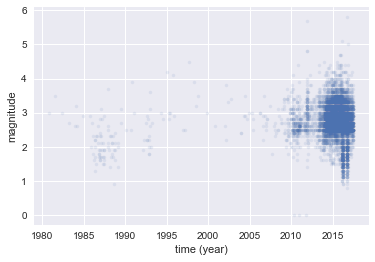

In [249]:
# Plot time vs. magnitude
plt.plot(time, mags, marker='.', linestyle='none', alpha=0.1)

plt.xlabel('time (year)')
plt.ylabel('magnitude')
plt.show()

In [356]:
time_flt_array = np.array(times_float)

In [357]:
time_flt_1 = time_flt_array[time_flt_array >= 1980]

In [385]:
time_flt_2 = time_flt_1[time_flt_1 <= 2017.5]

In [386]:
len(time_flt_2)

8924

In [361]:
mags_1 = mags_array[time_flt_array >= 1980]

In [387]:
mags_2 = mags_1[time_flt_1 <= 2017.5]

In [388]:
len(mags_2)

8924

In [365]:
time_flt_3 = time_flt_2[mags_2 >= 3.0]

In [369]:
list(time_flt_3)

[1980.8372161751647,
 1981.5298123585744,
 1982.3397161973617,
 1984.0893425643708,
 1987.0648559424149,
 1987.93604009069,
 1989.5527546429478,
 1990.8730302321155,
 1991.0635853278793,
 1992.9613357518394,
 1993.0375688245178,
 1994.3271099277017,
 1995.0483859531962,
 1995.2615891752282,
 1995.417217444191,
 1995.705082865931,
 1997.6830631947616,
 1998.325595563166,
 1998.518578274353,
 1998.8314714041094,
 1999.8184169954973,
 2002.1043516489092,
 2002.416661276636,
 2002.8023177638254,
 2004.4358736044521,
 2004.8935734858576,
 2005.3081374965122,
 2006.2059939707003,
 2006.2631019514206,
 2006.7662353113901,
 2007.4069698791857,
 2008.44120963724,
 2008.8313261247463,
 2009.075264759957,
 2009.0899984148273,
 2009.1419770024734,
 2009.1495705013317,
 2009.1873414491372,
 2009.454739631532,
 2009.4876012731481,
 2009.5019688051752,
 2009.5578120180112,
 2009.6555217697235,
 2009.6575515601219,
 2009.8107239259894,
 2009.8702302555807,
 2009.8757089402588,
 2009.8776261342591,
 20

In [389]:
time_flt_pre = time_flt_3[time_flt_3 < 2010]
time_flt_post = time_flt_3[time_flt_3 > 2010]

In [390]:
len(time_flt_post)

2432

In [378]:
dt_pre_list = []

for i in range(1,len(time_flt_pre)):
    dt_pre_list.append((time_flt_pre[i] - time_flt_pre[i-1]) * 365)

In [379]:
dt_pre = np.array(dt_pre_list)

In [380]:
dt_pre

array([2.52797607e+02, 2.95614901e+02, 6.38613624e+02, 1.08606238e+03,
       3.17982214e+02, 5.90100812e+02, 4.81900590e+02, 6.95526100e+01,
       6.92678905e+02, 2.78250715e+01, 4.70682503e+02, 2.63265749e+02,
       7.78191760e+01, 5.68043182e+01, 1.05070879e+02, 7.21962820e+02,
       2.34524314e+02, 7.04386896e+01, 1.14205992e+02, 3.60235141e+02,
       8.34366148e+02, 1.13993014e+02, 1.40764618e+02, 5.96247882e+02,
       1.67060457e+02, 1.51315864e+02, 3.27717613e+02, 2.08444130e+01,
       1.83643676e+02, 2.33868117e+02, 3.77497512e+02, 1.42392518e+02,
       8.90376019e+01, 5.37778403e+00, 1.89721845e+01, 2.77162708e+00,
       1.37863959e+01, 9.76003366e+01, 1.19944992e+01, 5.24414919e+00,
       2.03827727e+01, 3.56640594e+01, 7.40873495e-01, 5.59079135e+01,
       2.17198103e+01, 1.99971991e+00, 6.99775810e-01, 1.19004729e+01,
       9.08850174e+00, 4.74282720e+00, 8.78014236e-01, 6.85203079e+00])

In [381]:
dt_post_list = []

for i in range(1,len(time_flt_post)):
    dt_post_list.append((time_flt_post[i] - time_flt_post[i-1]) * 365)

In [382]:
dt_post = np.array(dt_post_list)

In [384]:
# ignoring first earthquake of 2010 - last earthquake of 2009
# ignoring first earthquake after midway point of 2017
dt_post

array([1.21727083e+00, 5.97187505e-03, 1.92131238e+00, ...,
       7.49788553e+00, 2.22501088e+00, 1.47027269e+00])

## Comparing mean inter-quake times, for large quakes, before & after fracking 

In [397]:
# Compute mean interearthquake time (that is, earthquake frequency)
mean_dt_pre = np.mean(dt_pre)
mean_dt_post = np.mean(dt_post)

# Draw 10,000 bootstrap replicates of the mean
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post, np.mean, size=10000)

# Compute the confidence interval
conf_int_pre = np.percentile(bs_reps_pre, [2.5, 97.5])
conf_int_post = np.percentile(bs_reps_post, [2.5, 97.5])

# Print the results
print("""1980 through 2009
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_pre, *conf_int_pre))

print("""
2010 through mid-2017
mean time gap: {0:.2f} days
95% conf int: [{1:.2f}, {2:.2f}] days""".format(mean_dt_post, *conf_int_post))

1980 through 2009
mean time gap: 204.48 days
95% conf int: [140.65, 276.34] days

2010 through mid-2017
mean time gap: 1.12 days
95% conf int: [0.97, 1.29] days


In [398]:
# Null hypothesis is that mean inter-earthquake time is the same pre-2010 as post-2010 in Oklahoma
# Compute the observed test statistic, which is obviously positive
mean_dt_diff = mean_dt_pre - mean_dt_post

# Shift the post-2010 data to have the same mean as the pre-2010 data, due to null hypothesis
dt_post_shift = dt_post - mean_dt_post + mean_dt_pre
# Or we could shift dt_pre

# Compute 10,000 bootstrap replicates from arrays
bs_reps_pre = dcst.draw_bs_reps(dt_pre, np.mean, size=10000)
bs_reps_post = dcst.draw_bs_reps(dt_post_shift, np.mean, size=10000)

# Get replicates of difference of means
bs_reps = bs_reps_pre - bs_reps_post

# Compute and print the p-value
p_val = np.sum(bs_reps >= mean_dt_diff) / 10000
print('p =', p_val)

p = 0.0


Performing this hypothesis test was just for practice, as the conclusion is clear.  We can reject the null hypothesis that the mean inter-earthquake time is the same.

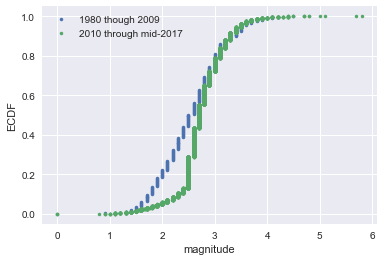

In [399]:
# Get magnitudes before and after 2010, now including quakes with magnitude less than 3
mags_pre = mags_2[time_flt_2 < 2010]
mags_post = mags_2[time_flt_2 > 2010]

# Generate ECDFs
plt.plot(*dcst.ecdf(mags_pre), linestyle='none', marker='.')
plt.plot(*dcst.ecdf(mags_post), linestyle='none', marker='.')

# Label axes and show plot
plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.legend(('1980 though 2009', '2010 through mid-2017'), loc='upper left')
plt.show()

Both curves seem to follow the Gutenberg--Richter Law, but with different completeness thresholds.

## Comparing $b$-values (seismicity) before & after fracking 

In [400]:
# Use 3 as our completeness threshold, just to be safe
# Compute b-value and confidence interval for pre-2010
b_pre, conf_int_pre = b_value(mags_pre, 3, perc=[2.5, 97.5], n_reps=10000)

# Compute b-value and confidence interval for post-2010
b_post, conf_int_post = b_value(mags_post, 3, perc=[2.5, 97.5], n_reps=10000)

# Report the results
print("""
1980 through 2009
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]

2010 through mid-2017
b-value: {3:.2f}
95% conf int: [{4:.2f}, {5:.2f}]
""".format(b_pre, *conf_int_pre, b_post, *conf_int_post))


1980 through 2009
b-value: 0.74
95% conf int: [0.53, 0.96]

2010 through mid-2017
b-value: 0.62
95% conf int: [0.60, 0.65]



For our final hypothesis test, our null hypothesis is that the $b$-values are the same, before and after fracking.  This hypothesis implicitly assumes that the magnitudes pre- and post-2010 are identically distributed (specifically exponentially), so we perform a permutation test.

In [402]:
# Only magnitudes above completeness threshold
mags_pre = mags_pre[mags_pre >= 3]
mags_post = mags_post[mags_post >= 3]

# Observed difference in mean magnitudes
# This is going to be negative
diff_obs = np.mean(mags_post) - np.mean(mags_pre)

# Generate permutation replicates
# Order of first two components matters!
perm_reps = dcst.draw_perm_reps(mags_post, mags_pre, dcst.diff_of_means, size=10000)

# Compute and print p-value
p_val = np.sum(perm_reps < diff_obs) / 10000
print('p =', p_val)

p = 0.1032


So we cannot reject the null hypothesis that the seismicity is the same in Oklahoma, pre- and post-2010.

### Misc. Work

In [315]:
time_mag_dict = {}

for i in range(len(mags_array)):
    time_mag_dict[times_float[i]] = mags_array[i]

In [316]:
len(time_mag_dict)

8977

In [317]:
len(mags_array)

8978

In [393]:
subdict_1 = {}

for k in time_mag_dict.keys():
    if k >= 1980 and k <= 2017.5:
        subdict_1[k] = time_mag_dict[k]

In [394]:
len(subdict_1)

8923

In [395]:
subdict_2 = {}

for k,v in subdict_1.items():
    if v >= 3.0:
        subdict_2[k] = v

In [396]:
times_3 = list(subdict_2.keys())

In [367]:
len(times_3)

2485

In [340]:
timedelts = []

for i in range(1,len(times_3)):
    timedelt = (times_3[i] - times_3[i-1]) * 365
    timedelts.append(timedelt)